## LightGBM

In [1]:
import pandas as pd
import numpy as np

import lightgbm as lgbm
import pickle
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('/workspace/kaggle_data/train.csv')
df = df.drop('full_text',axis = 1)
#df.head()
# 田中特徴量
df1 = pd.read_csv('/workspace/kaggle_data/conventions_eda_data.csv')
#df1.head()
# 丸ちゃん特徴量
df5 = pd.read_csv('/workspace/kaggle_data/mistake_features.csv')
df5.head()

,style,whitespace,locale-violation,misspelling,typographical,inconsistency,duplication,uncategorized,grammar_mistakes,error_length,sum_mistakes
0,0,1,0,8,2,0,0,0,2,58,13
1,2,0,0,25,5,0,0,0,8,145,40
2,0,0,0,7,2,0,0,0,1,56,10
3,1,0,0,3,11,0,0,0,1,76,16
4,0,1,0,13,2,0,0,0,2,170,18


In [3]:
# 田中
df['word_count'] = df1['word_count']
df['miss_count'] = df1['miss_count']
df['bos_count'] = df1['bos_count']
df['week_months'] = df1['week_months']
df['small_count'] = df1['small_count']
df['miss_rate'] = df1['miss_rate']
df['small_rate'] = df1['small_rate']
df['log_miss_rate'] = df1['log_miss_rate']
df['log_small_rate'] = df1['log_small_rate']
df['sample'] = df1['sample']

# fold
#df['fold'] = df3['fold']


df['target-cohesion'] = df['cohesion']
df['target-syntax'] = df['syntax']
df['target-vocabulary'] = df['vocabulary']
df['target-phraseology'] = df['phraseology']
df['target-grammar'] = df['grammar']
df['target-conventions'] = df['conventions']

# まるちゃん
df['style'] = df5['style']
df['whitespace'] = df5['whitespace']
df['locale-violation'] = df5['locale-violation']
df['misspelling'] = df5['misspelling']
df['typographical'] = df5['typographical']
df['inconsistency'] = df5['inconsistency']
df['duplication'] = df5['duplication']
df['uncategorized'] = df5['uncategorized']
df['grammar_mistakes'] = df5['grammar_mistakes']
df['error_length'] = df5['error_length']
df['sum_mistakes'] = df5['sum_mistakes']

target_list = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions', 'text_id']
df = df.drop(target_list, axis = 1)
df.head()

,word_count,miss_count,bos_count,week_months,small_count,miss_rate,small_rate,log_miss_rate,log_small_rate,sample,...,whitespace,locale-violation,misspelling,typographical,inconsistency,duplication,uncategorized,grammar_mistakes,error_length,sum_mistakes
0,262,0,15,0,15,0.000000,0.057252,0.000000,0.055673,0.055673,...,1,0,8,2,0,0,0,2,58,13
1,533,1,4,0,4,0.001876,0.007505,0.001874,0.007477,0.010288,...,0,0,25,5,0,0,0,8,145,40
2,320,4,2,0,2,0.012500,0.006250,0.012423,0.006231,0.024864,...,0,0,7,2,0,0,0,1,56,10
3,727,1,2,0,2,0.001376,0.002751,0.001375,0.002747,0.004809,...,0,0,3,11,0,0,0,1,76,16
4,234,7,0,0,0,0.029915,0.000000,0.029476,0.000000,0.044214,...,1,0,13,2,0,0,0,2,170,18


In [4]:
df.to_csv('/workspace/kaggle_data/features.csv')

## モデルの学習

In [5]:
data_path = '/workspace/kaggle_data/10fold_dataset/'
save_path = '/workspace/kaggle_data/save_models/'


#ハイパーパラメータを設定
params = {'boosting_type': 'gbdt',
          #'boosting_type' : 'dart',
          
          #'objective': 'binary', 二値分類
          'objective': 'regression', #回帰
          
          
          'metric':'rmse',
          #'metric': {'l2', 'l1'}, 
          
          'num_leaves': 10,
          #'learning_rate': 0.05,
          #'feature_fraction': 0.9,
          #'bagging_fraction': 0.8,
          #'bagging_freq': 5,
          #'vervose': 0
         }

In [11]:
def train_lgbm(params, t_list, column, fold, df):
    print(f'fold:{fold}')
    print(f'columns:{column}')
    
    deberta_df = pd.read_csv(data_path + f'fold{fold}.csv')
    df['cohesion'] = deberta_df['cohesion']
    df['syntax'] = deberta_df['syntax']
    df['vocabulary'] = deberta_df['vocabulary']
    df['phraseology'] = deberta_df['phraseology']
    df['grammar'] = deberta_df['grammar']
    df['conventions'] = deberta_df['conventions']
    df['fold'] = deberta_df['fold']
    
    df_train = df[df.fold != fold]
    df_valid = df[df.fold == fold]
        
    # 学習データ
    x_train = df_train.drop(t_list, axis = 1)
    y_train = df_train[f'target-{column}']
        
    # 評価用データ
    x_valid = df_valid.drop(t_list, axis = 1)
    y_valid = df_valid[f'target-{column}']
        
    categorical_features = []
        
    #LightGBM用の訓練データセットを作成
    lgb_train = lgbm.Dataset(x_train,y_train,categorical_feature=categorical_features,free_raw_data=False)

    #LightGBM用の評価データセットを作成
    lgb_eval = lgbm.Dataset(x_valid,y_valid,reference=lgb_train,categorical_feature=categorical_features,free_raw_data=False)

    #LightGBMの学習
    lgbm_model = lgbm.train(params,
                            lgb_train,
                            valid_sets=[lgb_train,lgb_eval],
                            verbose_eval=100,
                            # 計算回数
                            num_boost_round=1000,
                            early_stopping_rounds= 200
                           )
    
    file = f'lgbm_{column}_{fold}.pkl'
    pickle.dump(lgbm_model, open(save_path + file, 'wb'))
    
    del df, lgb_train, lgb_eval, lgbm_model
    return

## モデルを一つ作成

In [12]:
input_df = pd.read_csv('/workspace/kaggle_data/features.csv',index_col=0)
fold = 0
columns_name = 'conventions'
target_list = ['target-cohesion','target-syntax','target-vocabulary','target-phraseology','target-grammar','target-conventions', 'fold']

train_lgbm(params, target_list, columns_name, fold, input_df)

fold:0
columns:conventions
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3647
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.079972
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.360876	valid_1's rmse: 0.455613
[200]	training's rmse: 0.325425	valid_1's rmse: 0.462834
Early stopping, best iteration is:
[27]	training's rmse: 0.393822	valid_1's rmse: 0.446056


/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


## 複数のモデルを作成

In [13]:
input_df = pd.read_csv('/workspace/kaggle_data/features.csv',index_col=0)
fold = 0
column_list = ['cohesion','syntax','vocabulary','phraseology','grammar','conventions']
target_list = ['target-cohesion','target-syntax','target-vocabulary','target-phraseology','target-grammar','target-conventions', 'fold']

for i in column_list:
    columns_name = i
    for j in range(10):
        fold = j
        train_lgbm(params, target_list, columns_name, fold, input_df)

fold:0
columns:cohesion
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3647
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.123295
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.378133	valid_1's rmse: 0.495176
[200]	training's rmse: 0.342577	valid_1's rmse: 0.501286
Early stopping, best iteration is:
[17]	training's rmse: 0.42762	valid_1's rmse: 0.485838
fold:1
columns:cohesion
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3649
[LightGBM] [Info] Number of data points in the train set: 3520, number of used 

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

[200]	training's rmse: 0.340544	valid_1's rmse: 0.49172
Early stopping, best iteration is:
[29]	training's rmse: 0.415287	valid_1's rmse: 0.467203
fold:3
columns:cohesion
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3649
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.127273
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.384503	valid_1's rmse: 0.501548
[200]	training's rmse: 0.348683	valid_1's rmse: 0.510231
Early stopping, best iteration is:
[22]	training's rmse: 0.425462	valid_1's rmse: 0.488317
fold:4
columns:cohesion
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3647
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.129830
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.374414	valid_1's rmse: 0.480844
[200]	training's rmse: 0.336118	valid_1's rmse: 0.485199
Early stopping, best iteration is:
[22]	training's rmse: 0.416388	valid_1's rmse: 0.469221
fold:6
columns:cohesion
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3646
[LightGBM] [Info] Number of data point

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

[100]	training's rmse: 0.38072	valid_1's rmse: 0.461016
[200]	training's rmse: 0.344573	valid_1's rmse: 0.467204
Early stopping, best iteration is:
[27]	training's rmse: 0.418443	valid_1's rmse: 0.455218
fold:8
columns:cohesion
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3650
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.130114
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.374037	valid_1's rmse: 0.468878
[200]	training's rmse: 0.337294	valid_1's rmse: 0.473344
Early stopping, best iteration is:
[30]	training's rmse: 0.408482	valid_1's rmse: 0.465845
fold:9
columns:cohesion
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

[200]	training's rmse: 0.334359	valid_1's rmse: 0.5259
Early stopping, best iteration is:
[80]	training's rmse: 0.379221	valid_1's rmse: 0.521276
fold:0
columns:syntax
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3647
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.028267
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.351883	valid_1's rmse: 0.437213
[200]	training's rmse: 0.317188	valid_1's rmse: 0.44215
Early stopping, best iteration is:
[23]	training's rmse: 0.392563	valid_1's rmse: 0.432054
fold:1
columns:syntax
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=t

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3651
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.024006
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.350382	valid_1's rmse: 0.463782
[200]	training's rmse: 0.316614	valid_1's rmse: 0.471295
Early stopping, best iteration is:
[22]	training's rmse: 0.390697	valid_1's rmse: 0.456046
fold:3
columns:syntax
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3649
[LightGBM] [Info] Number of data points 

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

[200]	training's rmse: 0.318624	valid_1's rmse: 0.45245
Early stopping, best iteration is:
[43]	training's rmse: 0.3771	valid_1's rmse: 0.444562
fold:5
columns:syntax
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3647
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.029261
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.346021	valid_1's rmse: 0.454381
[200]	training's rmse: 0.310482	valid_1's rmse: 0.459327
Early stopping, best iteration is:
[21]	training's rmse: 0.388509	valid_1's rmse: 0.442716
fold:6
columns:syntax
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=t

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3650
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.037926
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.34687	valid_1's rmse: 0.443135
[200]	training's rmse: 0.311402	valid_1's rmse: 0.451122
Early stopping, best iteration is:
[19]	training's rmse: 0.392939	valid_1's rmse: 0.430899
fold:8
columns:syntax
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3650
[LightGBM] [Info] Number of data points i

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

[100]	training's rmse: 0.326485	valid_1's rmse: 0.433233
[200]	training's rmse: 0.293457	valid_1's rmse: 0.442606
Early stopping, best iteration is:
[23]	training's rmse: 0.361583	valid_1's rmse: 0.426458
fold:2
columns:vocabulary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3651
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.236080
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.332277	valid_1's rmse: 0.443929
[200]	training's rmse: 0.299886	valid_1's rmse: 0.447636
Early stopping, best iteration is:
[32]	training's rmse: 0.358846	valid_1's rmse: 0.441085
fold:3
columns:vocabulary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the ove

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3650
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.235369
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.33154	valid_1's rmse: 0.433356
[200]	training's rmse: 0.297757	valid_1's rmse: 0.439979
Early stopping, best iteration is:
[38]	training's rmse: 0.35702	valid_1's rmse: 0.427317
fold:5
columns:vocabulary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3647
[LightGBM] [Info] Number of data point

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

[100]	training's rmse: 0.326414	valid_1's rmse: 0.455795
[200]	training's rmse: 0.294275	valid_1's rmse: 0.457399
Early stopping, best iteration is:
[18]	training's rmse: 0.368401	valid_1's rmse: 0.449009
fold:7
columns:vocabulary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3650
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.246165
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.331083	valid_1's rmse: 0.407067
[200]	training's rmse: 0.298568	valid_1's rmse: 0.413892
Early stopping, best iteration is:
[21]	training's rmse: 0.369918	valid_1's rmse: 0.400167
fold:8
columns:vocabulary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the ove

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

fold:9
columns:vocabulary
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3648
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] Start training from score 3.233447
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.326061	valid_1's rmse: 0.420515
[200]	training's rmse: 0.292459	valid_1's rmse: 0.425559
Early stopping, best iteration is:
[21]	training's rmse: 0.364592	valid_1's rmse: 0.410078
fold:0
columns:phraseology
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3647
[LightGBM

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

[100]	training's rmse: 0.352157	valid_1's rmse: 0.466192
[200]	training's rmse: 0.316575	valid_1's rmse: 0.473643
Early stopping, best iteration is:
[23]	training's rmse: 0.390429	valid_1's rmse: 0.46239
fold:2
columns:phraseology
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3651
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.114489
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.358339	valid_1's rmse: 0.476124
[200]	training's rmse: 0.324097	valid_1's rmse: 0.484492
Early stopping, best iteration is:
[21]	training's rmse: 0.398474	valid_1's rmse: 0.459874
fold:3
columns:phraseology
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the ov

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3646
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.113352
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.351656	valid_1's rmse: 0.493384
[200]	training's rmse: 0.315489	valid_1's rmse: 0.495899
Early stopping, best iteration is:
[16]	training's rmse: 0.404197	valid_1's rmse: 0.477458
fold:7
columns:phraseology
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3650
[LightGBM] [Info] Number of data po

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

[100]	training's rmse: 0.35264	valid_1's rmse: 0.467976
[200]	training's rmse: 0.318507	valid_1's rmse: 0.475715
Early stopping, best iteration is:
[29]	training's rmse: 0.385897	valid_1's rmse: 0.463814
fold:9
columns:phraseology
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3648
[LightGBM] [Info] Number of data points in the train set: 3519, number of used features: 25
[LightGBM] [Info] Start training from score 3.113100
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.350183	valid_1's rmse: 0.477191
[200]	training's rmse: 0.315775	valid_1's rmse: 0.483283
Early stopping, best iteration is:
[25]	training's rmse: 0.385915	valid_1's rmse: 0.473018
fold:0
columns:grammar
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhe

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

[200]	training's rmse: 0.328361	valid_1's rmse: 0.496895
Early stopping, best iteration is:
[17]	training's rmse: 0.414051	valid_1's rmse: 0.4787
fold:1
columns:grammar
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3649
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.027557
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.361778	valid_1's rmse: 0.470716
[200]	training's rmse: 0.327072	valid_1's rmse: 0.47555
Early stopping, best iteration is:
[24]	training's rmse: 0.400095	valid_1's rmse: 0.465543
fold:2
columns:grammar
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

[100]	training's rmse: 0.368667	valid_1's rmse: 0.453086
[200]	training's rmse: 0.332735	valid_1's rmse: 0.461198
Early stopping, best iteration is:
[36]	training's rmse: 0.397724	valid_1's rmse: 0.448187
fold:4
columns:grammar
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3650
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.034659
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.364047	valid_1's rmse: 0.483652
[200]	training's rmse: 0.329034	valid_1's rmse: 0.490716
Early stopping, best iteration is:
[49]	training's rmse: 0.385131	valid_1's rmse: 0.48118
fold:5
columns:grammar
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_row_wise=true

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3650
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.033523
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.35726	valid_1's rmse: 0.484107
[200]	training's rmse: 0.320477	valid_1's rmse: 0.491914
Early stopping, best iteration is:
[28]	training's rmse: 0.39281	valid_1's rmse: 0.475804
fold:9
columns:grammar
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000330 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3648
[LightGBM] [Info] Number of data points i

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

[100]	training's rmse: 0.360876	valid_1's rmse: 0.455613
[200]	training's rmse: 0.325425	valid_1's rmse: 0.462834
Early stopping, best iteration is:
[27]	training's rmse: 0.393822	valid_1's rmse: 0.446056
fold:1
columns:conventions
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3649
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.078125
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.349121	valid_1's rmse: 0.469385
[200]	training's rmse: 0.315122	valid_1's rmse: 0.475747
Early stopping, best iteration is:
[23]	training's rmse: 0.385425	valid_1's rmse: 0.466896
fold:2
columns:conventions
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the o

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

Early stopping, best iteration is:
[20]	training's rmse: 0.399143	valid_1's rmse: 0.458532
fold:3
columns:conventions
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3649
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.082102
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.361694	valid_1's rmse: 0.438637
[200]	training's rmse: 0.325912	valid_1's rmse: 0.440386
Early stopping, best iteration is:
[21]	training's rmse: 0.401237	valid_1's rmse: 0.434426
fold:4
columns:conventions
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory i

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

[100]	training's rmse: 0.354588	valid_1's rmse: 0.438064
[200]	training's rmse: 0.318636	valid_1's rmse: 0.44292
Early stopping, best iteration is:
[22]	training's rmse: 0.394434	valid_1's rmse: 0.432291
fold:6
columns:conventions
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3646
[LightGBM] [Info] Number of data points in the train set: 3520, number of used features: 25
[LightGBM] [Info] Start training from score 3.075710
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.355521	valid_1's rmse: 0.461364
[200]	training's rmse: 0.320721	valid_1's rmse: 0.466479
Early stopping, best iteration is:
[31]	training's rmse: 0.384782	valid_1's rmse: 0.457073
fold:7
columns:conventions
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the ov

/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and

## モデルの読み込み

In [8]:
fold = 0
column = 'conventions'

t_list = ['target-cohesion','target-syntax','target-vocabulary','target-phraseology','target-grammar','target-conventions', 'fold']


lgbm = pickle.load(open(save_path + f'lgbm_{column}_{fold}.pkl', 'rb'))

df = pd.read_csv('/workspace/kaggle_data/features.csv',index_col=0)
deberta_df = pd.read_csv(data_path + f'fold{fold}.csv')
df['cohesion'] = deberta_df['cohesion']
df['syntax'] = deberta_df['syntax']
df['vocabulary'] = deberta_df['vocabulary']
df['phraseology'] = deberta_df['phraseology']
df['grammar'] = deberta_df['grammar']
df['conventions'] = deberta_df['conventions']
df['fold'] = deberta_df['fold']
df = df[df.fold == fold]
X = df.drop(t_list, axis = 1)
y = df[f'target-{column}']


# 予測
preds = lgbm.predict(X)
rmse = np.sqrt(mean_squared_error(y, preds))

print('RMSE : {:.4f}'.format(rmse))

RMSE : 0.4461


## 特徴量重要度の可視化

In [17]:
lgbm.plot_importance(lgbm_model, height = 0.8 ,figsize = (10,5),importance_type='split',)

AttributeError: 'Booster' object has no attribute 'plot_importance'

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

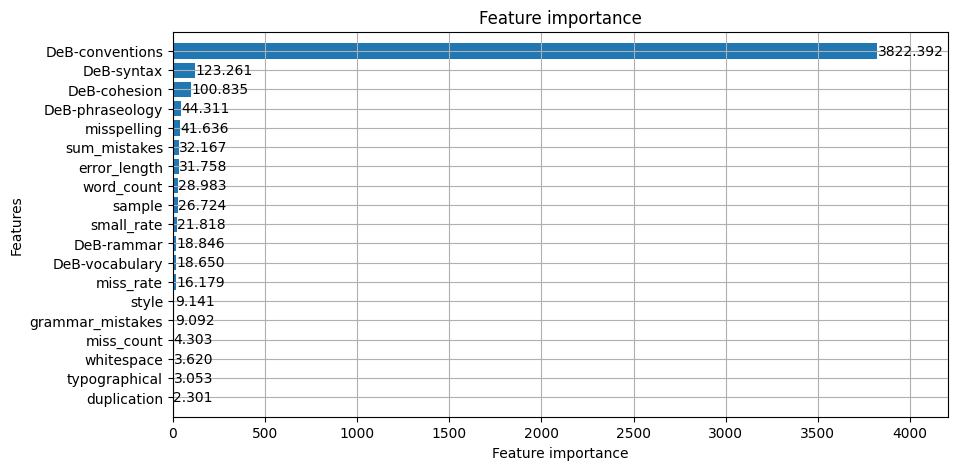

In [96]:
lgbm.plot_importance(lgbm_model, height = 0.8 ,figsize = (10,5),importance_type='gain',)

In [63]:
(0.488253 + 0.443372 + 0.452601 + 0.456041)/4

0.46006674999999997

In [42]:
0.44905
0.42415
0.430138
0.413216

0.413216

In [ ]:
0.447626
0.423544
0.430148
0.415338

In [53]:
(0.444326 + 0.419902 + 0.424559 + 0.40874)/4

0.42438175